# Chatbot - NLP 2021L
#### Authors:
#### <i>Mateusz Marciniewicz</i>
#### <i>Przemysław Bedełek</i>

# Dataset preparation

We are going to combine three datasets to form a reprsentative collection of sentences written in English.

## Human-robot text dataset

The dataset contains 2363 pairs of lines of text exchanged between a human and a robot.

Link to the dataset https://github.com/jackfrost1411/Generative-chatbot

In [1]:
import re

data_path = "Datasets/human_text.txt"
data_path2 = "Datasets/robot_text.txt"

# Defining lines as a list of each line
with open(data_path, 'r', encoding='utf-8') as f:
  contexts = f.read().split('\n')
  contexts = [re.sub(r"\[\w+\]",'hi',line) for line in contexts]
  contexts = [" ".join(re.findall(r"\w+",line)) for line in contexts]

with open(data_path2, 'r', encoding='utf-8') as f:
  responses = f.read().split('\n')
  responses = [re.sub(r"\[\w+\]",'',line) for line in responses]
  responses = [" ".join(re.findall(r"\w+",line)) for line in responses]
  
# sample context-response pairs
list(zip(contexts, responses))[:10]

[('hi', 'hi there how are you'),
 ('oh thanks i m fine this is an evening in my timezone', 'here is afternoon'),
 ('how do you feel today tell me something about yourself',
  'my name is rdany but you can call me dany the r means robot i hope we can be virtual friends'),
 ('how many virtual friends have you got',
  'i have many but not enough to fully understand humans beings'),
 ('is that forbidden for you to tell the exact number',
  'i ve talked with 143 users counting 7294 lines of text'),
 ('oh i thought the numbers were much higher how do you estimate your progress in understanding human beings',
  'i started chatting just a few days ago every day i learn something new but there is always more things to be learn'),
 ('how old are you how do you look like where do you live',
  'i m 22 years old i m skinny with brown hair yellow eyes and a big smile i live inside a lab do you like bunnies'),
 ('have you seen a human with yellow eyes you asked about the bunnies i haven t seen any re

## Alexa topical 

Topical-Chat is a knowledge-grounded human-human conversation dataset where the underlying knowledge spans 8 broad topics and conversation partners don’t have explicitly defined roles.

Link to the dataset https://github.com/alexa/Topical-Chat

In [2]:
import pandas as pd

df_topical = pd\
    .read_csv("Datasets/topical_chat.csv")[['conversation_id', 'message']]\
    .rename(columns={
        'conversation_id': 'id',
        'message': 'response'
        })

context = df_topical\
    .groupby("id")\
    .first()\
    .rename(columns={'response': 'context'})\
    .reset_index()

df_topical = df_topical[~df_topical.isin(context)]

topical_preprocessed = df_topical\
    .set_index('id')\
    .join(context.set_index('id'))\
    .reset_index()[['context', 'response']]

topical_preprocessed.sample(n=10)

,context,response
151011,Do you like sharks?,"Yes after the founder of Detroit, de la Mothe..."
67596,The Dr Sun Yat Sen garden must be really nice...,The Dr Sun Yat Sen garden must be really nice...
91095,hey there do you like Nintendo games?,What a great reference! Nicely done. Lou reed...
13587,Are you a big fan of dancing?,There was a group of climbers that climbed Br...
57765,Do you remember or did you see the 2004 anima...,"There's a lot of streamed content instead, bu..."
61674,"Hi, do you like jazz?",That's also who they created the drive thru f...
126734,This whole topic is really tough. Moonves jus...,I did not know that... 70's show was remade v...
17872,Hi! Do you like to use the library?,Hi! Do you like to use the library?
95395,"Hello there, do you use Google much?",For sure. It has saved me so many times.
21396,Are you a fan of Game of Thrones? It's won a ...,I wonder if the Internet will ever just get o...


In [3]:
contexts += list(topical_preprocessed.context)
responses += list(topical_preprocessed.response)

print(f"Total pairs count: {len(contexts)}")

Total pairs count: 190741


## Cornell Movie Dialogue Dataset

This corpus contains a large metadata-rich collection of fictional conversations extracted from raw movie scripts: 220,579 conversational exchanges between 10,292 pairs of movie characters involving 9,035 characters from 617 movies.

The preprocessing code is taken from https://www.kaggle.com/shashankasubrahmanya/preprocessing-cornell-movie-dialogue-corpus/
Link to the dataset https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

### Create a list of dialogues

We join two different files namely `movie_lines.tsv` and `movie_conversations.tsv` to finally produce a list of dialogues. This list is further stored as a `pickle` file for further processing.

In [4]:
movie_lines_features = ["LineID", "Character", "Movie", "Name", "Line"]
movie_lines = pd.read_csv(
    "Datasets/movie-dialogue/movie_lines.txt",
    sep = "\+\+\+\$\+\+\+", 
    engine = "python", 
    index_col = False, 
    names = movie_lines_features,
)

# Using only the required columns, namely, "LineID" and "Line"
movie_lines = movie_lines[["LineID", "Line"]]

# Strip the space from "LineID" for further usage and change the datatype of "Line"
movie_lines["LineID"] = movie_lines["LineID"].apply(str.strip)

movie_lines.head()

,LineID,Line
0,L1045,They do not!
1,L1044,They do to!
2,L985,I hope so.
3,L984,She okay?
4,L925,Let's go.


In [5]:
movie_conversations_features = ["Character1", "Character2", "Movie", "Conversation"]
movie_conversations = pd.read_csv(
    "Datasets/movie-dialogue/movie_conversations.txt",
    sep = "\+\+\+\$\+\+\+", 
    engine = "python", 
    index_col = False, 
    names = movie_conversations_features
)

# Again using the required feature, "Conversation"
movie_conversations = movie_conversations["Conversation"]

movie_conversations.head()

0     ['L194', 'L195', 'L196', 'L197']
1                     ['L198', 'L199']
2     ['L200', 'L201', 'L202', 'L203']
3             ['L204', 'L205', 'L206']
4                     ['L207', 'L208']
Name: Conversation, dtype: object

In [6]:
# This instruction takes lot of time, run it only once.
#conversation = [[str(list(movie_lines.loc[movie_lines["LineID"] == u.strip().strip("'"), "Line"])[0]).strip() for u in c.strip().strip('[').strip(']').split(',')] for c in movie_conversations]

#with open("./conversations.pkl", "wb") as handle:
 #   pkl.dump(conversation, handle)

### Create context and response pairs

In [7]:
import pickle as pkl
import numpy as np

with open("./conversations.pkl", "rb") as handle:
    conversation = pkl.load(handle)
    conversation = list(filter(lambda dialogue: len(dialogue) == 2, conversation))

conversation[:10]    

[["You're asking me out.  That's so cute. What's your name again?",
  'Forget it.'],
 ['Gosh, if only we could find Kat a boyfriend...',
  'Let me see what I can do.'],
 ['How is our little Find the Wench A Date plan progressing?',
  "Well, there's someone I think might be --"],
 ['There.', 'Where?'],
 ['You got something on your mind?',
  "I counted on you to help my cause. You and that thug are obviously failing. Aren't we ever going on our date?"],
 ['You have my word.  As a gentleman', "You're sweet."],
 ['How do you get your hair to look like that?',
  "Eber's Deep Conditioner every two days. And I never, ever use a blowdryer without the diffuser attachment."],
 ['Hi.', 'Looks like things worked out tonight, huh?'],
 ['You know Chastity?', 'I believe we share an art instructor'],
 ['Have fun tonight?', 'Tons']]

In [8]:
def generate_pairs(dialogues):
    
    context_list = []
    response_list = []
    
    for dialogue in dialogues:        
        context_list.append(dialogue[0])
        response_list.append(dialogue[1])
        
    return context_list, response_list

context_list, response_list = generate_pairs(conversation)

list(zip(context_list, response_list))[:10]

[("You're asking me out.  That's so cute. What's your name again?",
  'Forget it.'),
 ('Gosh, if only we could find Kat a boyfriend...',
  'Let me see what I can do.'),
 ('How is our little Find the Wench A Date plan progressing?',
  "Well, there's someone I think might be --"),
 ('There.', 'Where?'),
 ('You got something on your mind?',
  "I counted on you to help my cause. You and that thug are obviously failing. Aren't we ever going on our date?"),
 ('You have my word.  As a gentleman', "You're sweet."),
 ('How do you get your hair to look like that?',
  "Eber's Deep Conditioner every two days. And I never, ever use a blowdryer without the diffuser attachment."),
 ('Hi.', 'Looks like things worked out tonight, huh?'),
 ('You know Chastity?', 'I believe we share an art instructor'),
 ('Have fun tonight?', 'Tons')]

In [9]:
#Merge datasets
contexts += context_list
responses += response_list

### Data exploration

(0, 100)

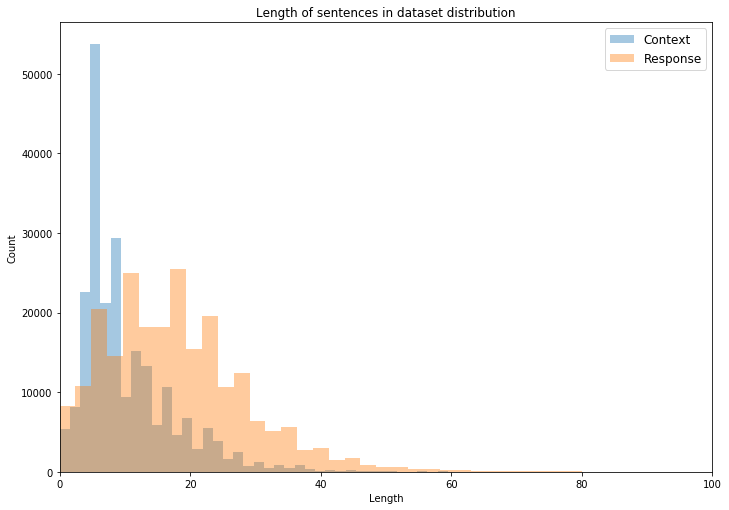

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd


contexts_len = [len(str(context).split()) for context in contexts]
responses_len = [len(str(response).split()) for response in responses]

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.distplot(contexts_len, kde=False, label='Context',bins=200)
sns.distplot(responses_len, kde=False, label='Response',bins=200)
plt.legend(prop={'size': 12})
plt.title('Length of sentences in dataset distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.xlim(0,100)


(0, 100)

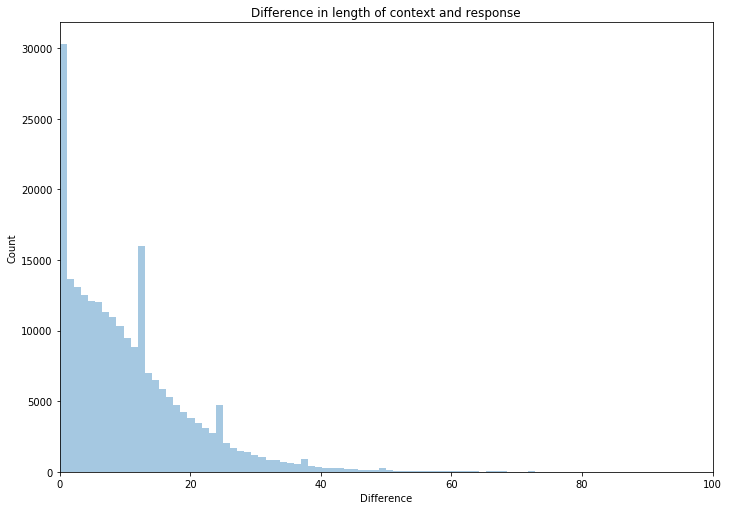

In [13]:
lenght_diff = [abs(con_len - res_len) for (con_len,res_len) in zip(contexts_len,responses_len)]

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(lenght_diff, kde=False,bins=400)
plt.title('Difference in length of context and response')
plt.xlabel('Difference')
plt.ylabel('Count')
plt.xlim(0,100)

### Dataset preparation - Conclusion

By observing the plots above and some samples of the sentences in our dataset, we can identify a few challanges that we are going to try tackle:
* there are lots of sentences whose length exceeds 20 tokens, especially in the responses collection,
* over 1/3 of pairs have a difference in length between the context and response, that exceeds 10 tokens
* the three datasets contain dialogues coming from different situations:
 - the human robot dataset consists mostly of small-talk conversations
 - the alexa topical dataset mainly contains technology oriented conversations
 - cornell-movie dialogues as the name sugests, originate from movies

The first two problems we will try to mitigate by filtering the datasets, in order to rule out the pairs that could be problematic to process for our seq2seq model.
Unfortunately the quality of data is not up to the highest  the last two datasets  don't represent perfectly the nature of typical human to human conversation, due to containing lots of brand/technology names or being completely out of context, as is the case with movie dialogues. 


## Data preprocessing

In this step we will preprocess our data in order to provide our model with high quality data, that will allow us to perform a succesful training process. We will filter, tokenize and pad our sentences so they will fit our model's input layer.

### Filtering
The first part of the data preprocessing is going to involve filtering out the following types of sentences:
* non string sentences
* strings not containing any letters
* where one of the sentences has 20 or more words
* whose difference in length is greater than 10
* non-english

In [14]:
import random

# Shuffle the dataset
sentences = list(zip(contexts,responses))
random.shuffle(sentences)
contexts, responses = zip(*sentences)

In [39]:
from langdetect import detect

def filter(contexts,responses,threshold):
    new_contexts = []
    new_responses = []
    for i in range(len(contexts)):
        # Drop non strings
        if isinstance(contexts[i],str) and isinstance(contexts[i],str):
            # Drop non alphabetical strings
            if re.search('[a-zA-Z]',contexts[i]) != None and re.search('[a-zA-Z]',responses[i]) != None :
                # Drop sentences that are to long
                if len(contexts[i].split()) <= threshold and len(responses[i].split()) <= threshold:
                    #Drop pairs with big difference in sentence lengths
                    if abs(len(contexts[i].split())-len(responses[i].split())) <= 10:
                        # Drop non-english sentences
                        if detect(responses[i])=='en' and detect(contexts[i])=='en':
                            new_contexts.append(contexts[i])
                            new_responses.append(responses[i])
    return new_contexts, new_responses

In [40]:
context_timesteps = response_timesteps = 20

In [41]:
contexts, responses = filter(contexts,responses,context_timesteps)

print(f"Contexts count: {len(contexts)}")
print(f"Response count: {len(responses)}")

Total pairs count: 83601
Total pairs count: 83601


Language detection takes a long time, and therefore remember to save the results and load them from file in further executions.

In [15]:
print(f"Total pairs count: {len(contexts)}")
contexts = np.array(contexts,dtype=str)
responses = np.array(responses,dtype=str)


pd.DataFrame(contexts).to_csv("contexts_20.csv")
pd.DataFrame(responses).to_csv("responses_20.csv")

In [16]:
import numpy as np
import pandas as pd



contexts = np.squeeze(pd.read_csv("contexts_20.csv", usecols=[1]).to_numpy()[:32000])
responses = np.squeeze(pd.read_csv("responses_20.csv",usecols=[1]).to_numpy()[:32000])

### Tokenization and padding

As always we are going to split our data into two separate subsets: training and testing dataset.
Besides that we are going to use tokenization and padding to transform the sequences into an unified
form of data, that could be passed to our model.

In [17]:
from tensorflow import keras
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [18]:
# Set the timesteps
context_timesteps = response_timesteps = 20

# Shuffle and split dataset into training and test subsets
def shuffle_split_data(contexts,responses,train_size, random_seed=50):
    np.random.seed(random_seed)
    
    #Shuffle indices
    indices = np.arange(len(contexts))
    np.random.shuffle(indices)
    
    #Select indices for both train and test subsets
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    #Split contexts and responses into train and test subsets
    contexts_train = np.array([contexts[i] for i in train_indices],dtype=str)
    contexts_test = np.array([contexts[i] for i in test_indices],dtype=str)
    
    responses_train = np.array([responses[i] for i in train_indices],dtype=str)
    responses_test = np.array([responses[i] for i in test_indices],dtype=str)
                              
    return contexts_train,contexts_test,responses_train,responses_test

# Mutate text to sequence of tokens
def to_seq(tokenizer, text, pad_length=None, padding_type='post'):
    encoded_text = tokenizer.texts_to_sequences(text)
    preproc_text = pad_sequences(encoded_text, padding=padding_type, maxlen=pad_length)
    
    return preproc_text

In [19]:
contexts_train, contexts_test, responses_train, responses_test = shuffle_split_data(contexts,responses,int(len(contexts)*4/5))

context_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
context_tokenizer.fit_on_texts(contexts_train)

response_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
response_tokenizer.fit_on_texts(responses_train)

contexts_seq = context_tokenizer.texts_to_sequences(contexts_train)
responses_seq = response_tokenizer.texts_to_sequences(contexts_train)

contexts_seq = pad_sequences(contexts_seq,padding='post',maxlen=context_timesteps)
responses_seq = pad_sequences(responses_seq,padding='post',maxlen=response_timesteps)


In [20]:
batch_size = 64
hidden_size = 96

context_vsize = max(context_tokenizer.index_word.keys()) + 1
response_vsize = max(response_tokenizer.index_word.keys()) + 1

## Model definition

The model that we are going to use is a seq2seq model created by Thushan Ganegedara (https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39). The author intented to implement this model for machine translation purposes, however we are going to use it for text generation of our chatbot. The model consists of an Encoder and Decoder build on GRU's, and an additional Attention Layer definded below.

In [21]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [22]:
from tensorflow.python.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed
from tensorflow.python.keras.models import Model

def define_nmt(hidden_size, batch_size, con_timesteps, con_vsize, res_timesteps, res_vsize):
    """ Defining a NMT model """

    # Define an input sequence and process it.
    if batch_size:
        encoder_inputs = Input(batch_shape=(batch_size, con_timesteps, con_vsize), name='encoder_inputs')
        decoder_inputs = Input(batch_shape=(batch_size, res_timesteps - 1, res_vsize), name='decoder_inputs')
    else:
        encoder_inputs = Input(shape=(con_timesteps, con_vsize), name='encoder_inputs')
        if res_timesteps:
            decoder_inputs = Input(shape=(res_timesteps - 1, res_vsize), name='decoder_inputs')
        else:
            decoder_inputs = Input(shape=(None, res_vsize), name='decoder_inputs')

    # Encoder GRU
    encoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')
    encoder_out, encoder_state = encoder_gru(encoder_inputs)

    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
    decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    # Concat attention input and decoder GRU output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    # Dense layer
    dense = Dense(res_vsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'], sample_weight_mode='temporal')

    full_model.summary()
    
    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(batch_size, con_timesteps, con_vsize), name='encoder_inf_inputs')
    encoder_inf_out, encoder_inf_state = encoder_gru(encoder_inf_inputs)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_state])

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1, res_vsize), name='decoder_word_inputs')
    encoder_inf_states = Input(batch_shape=(batch_size, con_timesteps, hidden_size), name='encoder_inf_states')
    decoder_init_state = Input(batch_shape=(batch_size, hidden_size), name='decoder_init')

    decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
    decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])
    
    return full_model,encoder_model,decoder_model

def infer_nmt(encoder_model, decoder_model, test_con_seq, con_vsize, res_vsize):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_con_seq: sequence of word ids
    :param con_vsize: int
    :param res_vsize: int
    :return:
    """

    test_res_seq = sents2sequences(response_tokenizer, ['sos'], res_vsize)
    test_con_onehot_seq = to_categorical(test_con_seq, num_classes=con_vsize)
    test_res_onehot_seq = np.expand_dims(to_categorical(test_res_seq, num_classes=res_vsize), 1)

    enc_outs, enc_last_state = encoder_model.predict(test_con_onehot_seq)
    dec_state = enc_last_state
    attention_weights = []
    res_text = ''
    for i in range(20):

        dec_out, attention, dec_state = decoder_model.predict([enc_outs, dec_state, test_res_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]
        

        if dec_ind == 0:
            break
        test_res_seq = sents2sequences(response_tokenizer, [response_index2word[dec_ind]], res_vsize)
        test_res_onehot_seq = np.expand_dims(to_categorical(test_res_seq, num_classes=res_vsize), 1)

        attention_weights.append((dec_ind, attention))
        res_text += response_index2word[dec_ind] + ' '

    return res_text, attention_weights

In [23]:
# Model creation
full_model, encoder_model, decoder_model = define_nmt(
        hidden_size=hidden_size, batch_size=batch_size,
        con_timesteps=context_timesteps, res_timesteps=response_timesteps,
        con_vsize=context_vsize, res_vsize=response_vsize)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(64, 20, 3568)]     0                                            
___________________________________________________________________________

### Training

Instead of using the fit() method, we will rely on the train_on_batch method, that allows us to spare some memory, but in return it requires us to manually handle the epochs and batches. 

In [58]:
from keras.utils.np_utils import to_categorical
n_epochs = 10

for epoch in range(n_epochs):
    losses = []
    for bi in range(0, contexts_seq.shape[0] - batch_size, batch_size):

        context_onehot_seq = to_categorical(contexts_seq[bi:bi + batch_size, :], num_classes=context_vsize)
        response_onehot_seq = to_categorical(responses_seq[bi:bi + batch_size, :], num_classes=response_vsize)

        full_model.train_on_batch([context_onehot_seq, response_onehot_seq[:, :-1, :]], response_onehot_seq[:, 1:, :])

        l = full_model.evaluate([context_onehot_seq, response_onehot_seq[:, :-1, :]], response_onehot_seq[:, 1:, :],
                                batch_size=batch_size, verbose=0)

        losses.append(l)
    if (epoch + 1) % 1 == 0:
        print("Loss in epoch {}: {}".format(epoch + 1, np.mean(losses)))



Loss in epoch 1: 0.5500268567148157
Loss in epoch 2: 0.5457863588854084
Loss in epoch 3: 0.5404301686139088
Loss in epoch 4: 0.5355640645395583
Loss in epoch 5: 0.5320273810542944
Loss in epoch 6: 0.5296116926978658
Loss in epoch 7: 0.527232084848632
Loss in epoch 8: 0.52460260536727
Loss in epoch 9: 0.522630216487808
Loss in epoch 10: 0.5219569811084139


In [16]:
tf.keras.models.save_model(full_model, 'new_model.h5')
tf.keras.models.save_model(encoder_model, 'new_encoder_model.h5')
tf.keras.models.save_model(decoder_model, 'new_decoder_model.h5')

Instead of retraining the model we are going to load our already trained model (15 epochs) from file. 

In [24]:
import tensorflow as tf



# full_model =  tf.keras.models.load_model('model_v5.h5', custom_objects={'AttentionLayer':AttentionLayer })
encoder_model =  tf.keras.models.load_model('encoder_v5.h5', custom_objects={'AttentionLayer':AttentionLayer })
decoder_model =  tf.keras.models.load_model('decoder_v5.h5', custom_objects={'AttentionLayer':AttentionLayer })

## Model evaluation

Firstly we will use the test dataset to generate a list of responses and we will have a look on some predictions of our model. Afterwards we are going to compare them to the original responses and calculate a few metrics to evaluate our model.

In [25]:
# Creating vocab dictionaries and inference models

""" Index2word """
context_index2word = dict(zip(context_tokenizer.word_index.values(), context_tokenizer.word_index.keys()))
response_index2word = dict(zip(response_tokenizer.word_index.values(), response_tokenizer.word_index.keys()))

In [26]:
from keras.utils.np_utils import to_categorical

def sents2sequences(tokenizer, sentences, reverse=False, pad_length=None, padding_type='post'):
    encoded_text = tokenizer.texts_to_sequences(sentences)
    preproc_text = pad_sequences(encoded_text, padding=padding_type, maxlen=pad_length)
    if reverse:
        preproc_text = np.flip(preproc_text, axis=1)

    return preproc_text

Using TensorFlow backend.


In [29]:
gen_responses = []
for context in contexts_test:
    seq = sents2sequences(context_tokenizer, [context], pad_length=context_timesteps)
    response, _ = infer_nmt(
    encoder_model=encoder_model, decoder_model=decoder_model,
    test_con_seq=seq, con_vsize=context_vsize, res_vsize=response_vsize)
    gen_responses.append(response)
pd.DataFrame(gen_responses).to_csv("gen_responses.csv")

In [30]:
gen_responses = np.squeeze(pd.read_csv("gen_responses.csv",usecols=[1]).to_numpy())

In [41]:
for i in range(10,12):
    print("Context: {}".format(contexts_test[i]))
    print("Original respose: {}".format(responses_test[i]))
    print("Generated respose: {}".format(gen_responses[i]))

Context:  Hi! Are you into soccer or the FIFA world cup football?
Original respose:  I know it's crazy, the Olympics are the same way. Maybe there's an increase and tourism afterwards that may help.
Generated respose: i wonder if you soccer a soccer fan 
Context:  Do you like the piano?
Original respose:  Not like the one concert Pink Floyd recorded Live, no audience!
Generated respose: do you like the piano 


You can observe that the predictions almost match the context, which shows that our model isn't performing too well on previously unseen data. It's probably due to the model being underfitted, as 15 epochs is absolutely not enough to fully train such model.

### BLEU

In [47]:
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu, sentence_bleu


def bleu(ref, gen):
    ''' 
    calculate pair wise bleu score. uses nltk implementation
    Args:
        references : a list of reference sentences 
        candidates : a list of candidate(generated) sentences
    Returns:
        bleu score(float)
    '''
    ref_bleu = []
    gen_bleu = []
    for l in gen:
        l = str(l)
        gen_bleu.append(l.split())
    for i,l in enumerate(ref):
        l = str(l)
        ref_bleu.append([l.split()])
    cc = SmoothingFunction()
    score_bleu = corpus_bleu(ref_bleu, gen_bleu, weights=(0, 1, 0, 0), smoothing_function=cc.method4)
    return score_bleu

print("Bleu score: {}".format(bleu(responses_test,gen_responses)))

Bleu score: 0.023382586587663283


### Rouge

In [48]:
import itertools

#supporting function
def _split_into_words(sentences):
  """Splits multiple sentences into words and flattens the result"""
  return list(itertools.chain(*[str(_).split(" ") for _ in sentences]))

#supporting function
def _get_word_ngrams(n, sentences):
  """Calculates word n-grams for multiple sentences.
  """
  assert len(sentences) > 0
  assert n > 0

  words = _split_into_words(sentences)
  return _get_ngrams(n, words)

#supporting function
def _get_ngrams(n, text):
  """Calcualtes n-grams.
  Args:
    n: which n-grams to calculate
    text: An array of tokens
  Returns:
    A set of n-grams
  """
  ngram_set = set()
  text_length = len(text)
  max_index_ngram_start = text_length - n
  for i in range(max_index_ngram_start + 1):
    ngram_set.add(tuple(text[i:i + n]))
  return ngram_set

def rouge_n(reference_sentences, evaluated_sentences, n=2):
  """
  Computes ROUGE-N of two text collections of sentences.
  Source: http://research.microsoft.com/en-us/um/people/cyl/download/
  papers/rouge-working-note-v1.3.1.pdf
  Args:
    evaluated_sentences: The sentences that have been picked by the summarizer
    reference_sentences: The sentences from the referene set
    n: Size of ngram.  Defaults to 2.
  Returns:
    recall rouge score(float)
  Raises:
    ValueError: raises exception if a param has len <= 0
  """
  if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")

  evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
  reference_ngrams = _get_word_ngrams(n, reference_sentences)
  reference_count = len(reference_ngrams)
  evaluated_count = len(evaluated_ngrams)

  # Gets the overlapping ngrams between evaluated and reference
  overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
  overlapping_count = len(overlapping_ngrams)

  # Handle edge case. This isn't mathematically correct, but it's good enough
  if evaluated_count == 0:
    precision = 0.0
  else:
    precision = overlapping_count / evaluated_count

  if reference_count == 0:
    recall = 0.0
  else:
    recall = overlapping_count / reference_count

  f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))

  #just returning recall count in rouge, useful for our purpose
  return recall

print("Rouge_n score: {}".format(rouge_n(responses_test,gen_responses)))

Rouge_n score: 0.060244470314318975


### Attention plotting

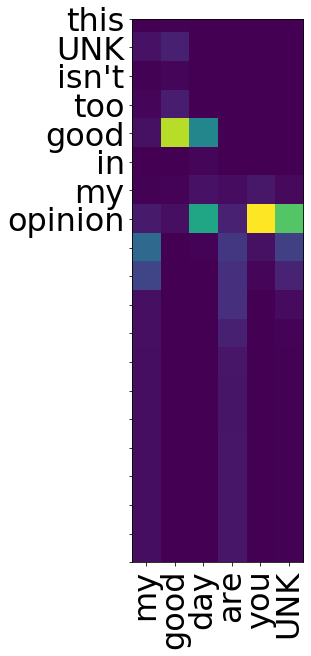

In [59]:
import matplotlib.pyplot as plt

def plot_attention_weights(encoder_inputs, attention_weights, con_id2word, res_id2word):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param con_id2word: dict
    :param res_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
    attention_mat = np.transpose(np.array(mats))

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(attention_mat)
   
    dec_inputs = np.array([inp for inp in dec_inputs if inp != 0])
    encoder_inputs = np.array([inp for inp in encoder_inputs.ravel() if inp != 0])
    
    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels([res_id2word[inp] for inp in dec_inputs ])
    ax.set_yticklabels([con_id2word[inp] for inp in encoder_inputs.ravel()])

    ax.tick_params(labelsize=32)
    ax.tick_params(axis='x', labelrotation=90)
    plt.show()

seq = sents2sequences(context_tokenizer, ["This chatbot isn't too good in my opinion"], pad_length=context_timesteps)
response, attn_weights = infer_nmt(
encoder_model=encoder_model, decoder_model=decoder_model,
test_con_seq=seq, con_vsize=context_vsize, res_vsize=response_vsize)
plot_attention_weights(seq, attn_weights, context_index2word, response_index2word)
    

### Conclusions
The chatbot is severely underperforming. This might be down to it being undertrained, trash data, significant mistakes in the model architecture or all at the same time. BLEU under 10 indicates that the model is basically unusable and the attention map shows, that the attention layer is certainly not working correctly (you would expect high values on the diagonal contrary to what we've got here). Nevertheless we highly encourage you test it out, just for fun purposes:

In [60]:
class ChatBot:
    negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
    exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
    #Method to start the conversation
    def start_chat(self):
        user_response = input("Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?\n")

        if user_response in self.negative_responses:
          print("Ok, have a great day!")
          return
        self.chat(user_response)
    #Method to handle the conversation
    def chat(self, reply):
        while not self.make_exit(reply):
            reply = input(self.generate_response(reply)+"\n")

    #Method that will create a response using seq2seq model we built
    def generate_response(self, user_input):
        input_seq = sents2sequences(context_tokenizer, [user_input], pad_length=context_timesteps)
        chatbot_response, attn_weights = infer_nmt(
            encoder_model=encoder_model, decoder_model=decoder_model,
            test_con_seq=input_seq, con_vsize=context_vsize, res_vsize=response_vsize)
        return chatbot_response
    #Method to check for exit commands
    def make_exit(self, reply):
        for exit_command in self.exit_commands:
            if exit_command in reply:
                print("Ok, have a great day!")
                return True
        return False
  


In [63]:
chatbot = ChatBot()
chatbot.start_chat()

Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?
How is the weather?
how are you this 
quit
Ok, have a great day!
